In [97]:
import torch
import torch.distributions as D

class MixtureDistribution(D.Distribution):
    def __init__(self, base_dist, uniform_low, uniform_high, mixture_weight):
        super().__init__(validate_args=False)
        self.base_dist = base_dist
        self.uniform_dist = D.Uniform(uniform_low, uniform_high)
        self.mixture_weight = mixture_weight
        
    def sample(self):
        base_samples = self.base_dist.sample()
        uniform_samples = self.uniform_dist.sample(sample_shape=base_samples.shape)

        mixture_samples = torch.bernoulli(self.mixture_weight * torch.ones_like(base_samples)).bool()
        print(uniform_samples)

        samples = torch.where(mixture_samples, uniform_samples, base_samples)
        return samples

    def log_prob(self, x):
        base_log_prob = self.base_dist.log_prob(x)
        uniform_log_prob = self.uniform_dist.log_prob(x)

        base_weighted_log_prob = torch.log(1 - self.mixture_weight) + base_log_prob
        uniform_weighted_log_prob = torch.log(self.mixture_weight) + uniform_log_prob
        
        print(base_weighted_log_prob.shape, 
              uniform_weighted_log_prob.shape,
              torch.stack([base_weighted_log_prob, uniform_weighted_log_prob]).shape)

        return torch.logsumexp(
            torch.stack([base_weighted_log_prob, uniform_weighted_log_prob], axis=-1),
            dim=-1
        )

In [118]:
from torch.distributions import SigmoidTransform

base_prop_dist = D.normal.Normal(
            loc=torch.zeros((4096, 3)),
            scale=torch.exp(torch.ones((4096, 3))*-2.)
        )

prop_normal_sigmoid = D.TransformedDistribution(base_prop_dist, [SigmoidTransform()])

mixture_dist = MixtureDistribution(
    prop_normal_sigmoid,
    torch.tensor(0.0),
    torch.tensor(1.0),
    torch.tensor(0.9)
)

In [119]:
samples = mixture_dist.sample()

tensor([[0.1769, 0.8305, 0.1575],
        [0.3140, 0.1848, 0.5228],
        [0.9617, 0.8787, 0.5918],
        ...,
        [0.6684, 0.2087, 0.9285],
        [0.2472, 0.9228, 0.5094],
        [0.1451, 0.7662, 0.6794]])


(0.0, 1.0)

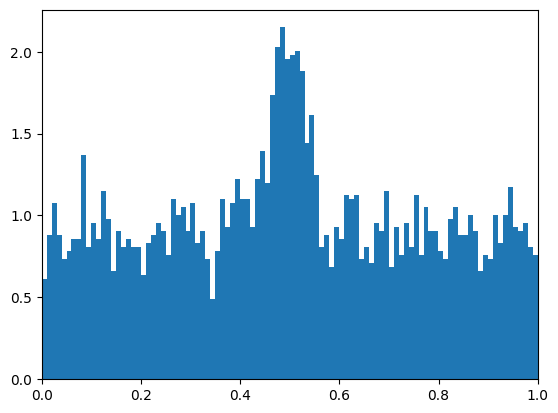

In [120]:
slice = samples[:, 2]
# plot histogram between 0 and 1
import matplotlib.pyplot as plt
plt.hist(slice.numpy(), bins=100, density=True)
# force hist between 0 and 1
plt.xlim(0, 1)

torch.Size([4096, 3]) torch.Size([4096, 3]) torch.Size([2, 4096, 3])
torch.Size([4096, 3]) torch.Size([4096, 3]) torch.Size([2, 4096, 3])


(-5.0, 5.0)

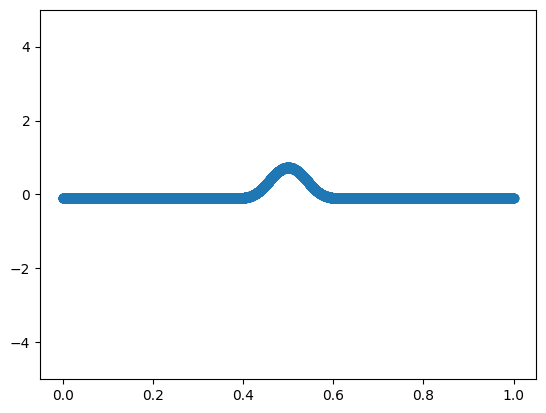

In [121]:
mixture_dist.log_prob(samples).shape
plt.scatter(samples, mixture_dist.log_prob(samples))
plt.ylim(-5, 5)

torch.Size([4096, 3])